In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import keras
import pandas as pd
import math
import joblib

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import display
from fuel.datasets.hdf5 import H5PYDataset
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
digit_size = 28
img_rows, img_cols, img_chns = 28, 28, 1
latent_dim = 128

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) / 255.
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


# Load Models

In [4]:
encoder_path = "saved_models/vae-m1-mnist-encoder.hdf5"
encoder = keras.models.load_model(encoder_path)

generator_path = "saved_models/vae-m1-mnist-generator.hdf5"
generator = keras.models.load_model(generator_path)

/home/brian/anaconda3/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Sample Some Random Images

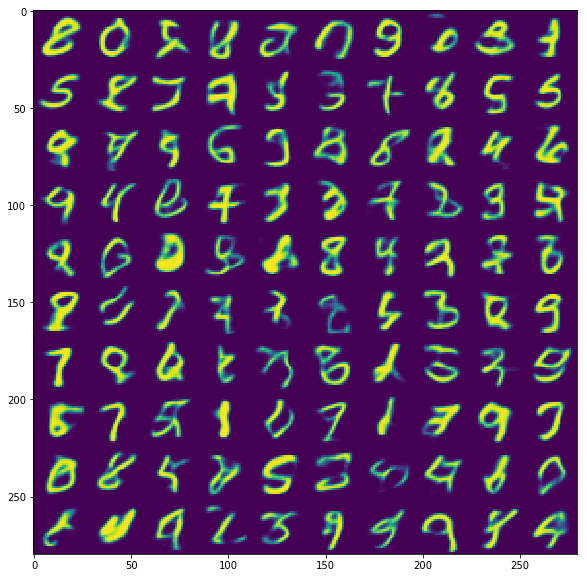

In [5]:
n = 10
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[:, :]

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Load features

In [6]:
batch_size = 100
X_test_decoded = encoder.predict(X_test, batch_size=batch_size)

results = []
for sample_size in [100, 500, 1000, 2000, 5000]:
    start = time.time()
    print('Fitting with sample_size: {}'.format(sample_size))
    model = SVC()
   
    if sample_size < len(X_train):
        sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train), random_state=0)
        _, index = sss.split(X_train, y_train)
        X, y = X_train[index[1]], y_train[index[1]]
    else:
        X, y = X_train, y_train
    
    X_latent = encoder.predict(X, batch_size=batch_size)
    model.fit(X_latent, y.ravel())
    
    X_test_latent = encoder.predict(X_test, batch_size=batch_size)
    y_pred = model.predict(X_test_latent)
    score = accuracy_score(y_test, y_pred)
    
    end = time.time()
    elapsed = end - start
    print(' * Accuracy: %.1f %%' % (100. * score))
    print(' * Fit time elapsed: %.1fs' % elapsed)
    results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

Fitting with sample_size: 200
 * Accuracy: 79.9 %
 * Fit time elapsed: 1.3s
Fitting with sample_size: 600
 * Accuracy: 89.2 %
 * Fit time elapsed: 2.1s
Fitting with sample_size: 1000
 * Accuracy: 90.8 %
 * Fit time elapsed: 2.7s
Fitting with sample_size: 2000
 * Accuracy: 92.2 %
 * Fit time elapsed: 4.3s
Fitting with sample_size: 5000
 * Accuracy: 93.4 %
 * Fit time elapsed: 8.6s


In [7]:
df = pd.DataFrame(results)
display(df)
df.to_csv('vae_m1_mnist_results.csv', index=False)

,accuracy,sample_size,time
0,0.7989,200,1.335822
1,0.8922,600,2.100606
2,0.9080,1000,2.748884
3,0.9218,2000,4.321148
4,0.9344,5000,8.598453
